<a href="https://colab.research.google.com/github/akfalah/machine-learning/blob/main/2241720184_AhmadKhoirulFalah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Import library yang diperlukan

from google.colab import drive
import zipfile
import random
import dlib
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [2]:
# @title Mount Google Drive & Load Data

drive.mount('/content/drive')

zip_path = '/content/drive/My Drive/kuliah/dataset.zip'

extract_path = 'images'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


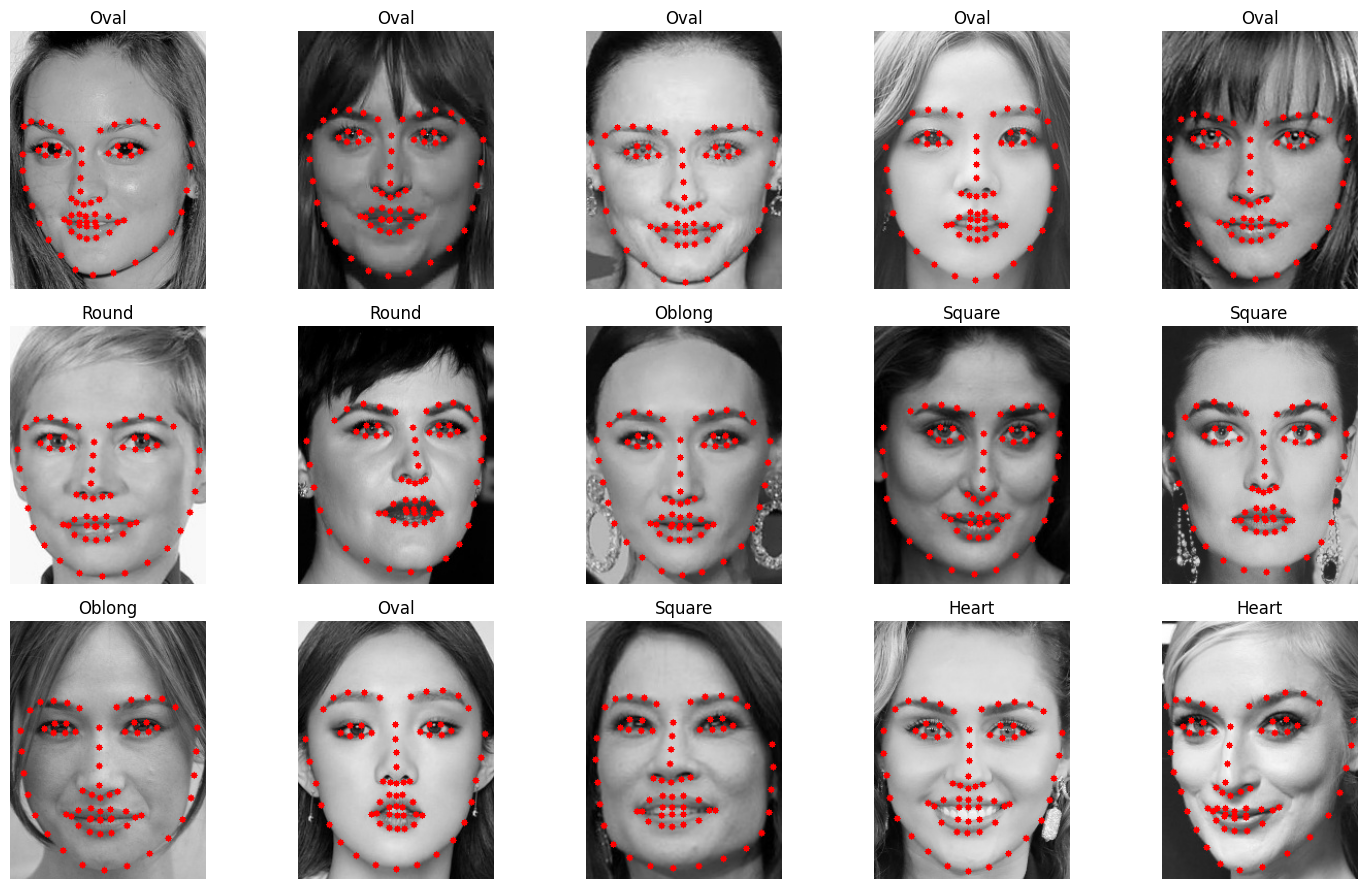

In [3]:
# @title Inisialisasi Dlib dan Visualisasi Contoh Deteksi Wajah

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/kuliah/shape_predictor_68_face_landmarks.dat')

image_dir = 'images/dataset'

image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

selected_images = random.sample(image_files, 15)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for ax, image_file in zip(axes, selected_images):
    image_path = os.path.join(image_dir, image_file)
    image = cv.imread(image_path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)
        landmarks_np = np.array([[p.x, p.y] for p in landmarks.parts()])


        for (x, y) in landmarks_np:
            cv.circle(image, (x, y), 3, (0, 0, 255), -1)

    label = image_file.split('(')[0]

    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    ax.imshow(image_rgb, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# @title Ekstraksi Fitur dan Preprocessing

features_list = []
labels = []

def extract_features(image_path):
    img = cv.imread(image_path)

    if img is None:
        return None

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    faces = detector(gray)

    if len(faces) == 0:
        return None

    shape = predictor(img, faces[0])
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])

    return landmarks.flatten()

for filename in os.listdir(extract_path + '/dataset'):
    if filename.endswith('.jpg') or filename.endswith('.png'):

        label = filename.split('(')[0]


        features = extract_features(os.path.join(extract_path + '/dataset', filename))


        if features is not None:
            features_list.append(features)
            labels.append(label)

features_list = np.array(features_list)
labels = np.array(labels)
print("Jumlah label yang sudah diekstraksi:", len(labels))

Jumlah label yang sudah diekstraksi: 3958


In [5]:
# @title Split Data menjadi Train dan Test

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_list)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, y_encoded, test_size=0.2, random_state=42)

print(f'Jumlah data pelatihan (X_train): {X_train.shape[0]}')
print(f'Jumlah data pengujian (X_test): {X_test.shape[0]}')
print(f'Jumlah label pelatihan (y_train): {len(y_train)}')
print(f'Jumlah label pengujian (y_test): {len(y_test)}')

Jumlah data pelatihan (X_train): 3166
Jumlah data pengujian (X_test): 792
Jumlah label pelatihan (y_train): 3166
Jumlah label pengujian (y_test): 792


In [15]:
# @title Membangun dan Melatih Model ANN

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train_one_hot, epochs=50, batch_size=10, verbose=1)

y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)

y_pred_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3666 - loss: 1.5005
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5636 - loss: 1.1192
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5971 - loss: 1.0164
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6491 - loss: 0.9265
Epoch 5/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6649 - loss: 0.8647
Epoch 6/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6883 - loss: 0.8114
Epoch 7/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7277 - loss: 0.7389
Epoch 8/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7312 - loss: 0.6996
Epoch 9/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7438 - loss: 0.7046
Epoch 10/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7495 - loss: 0.6598
Epoch 11/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7438 - loss: 0.6482
Epoch 12/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [19]:
# @title Evaluasi Model untuk Data Train
print("Laporan Klasifikasi (Train):")
print(classification_report(y_train, y_pred_train))

accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'Akurasi ANN (Train): {accuracy_train}')

Laporan Klasifikasi (Train):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       644
           1       0.99      0.93      0.96       637
           2       0.97      0.96      0.96       625
           3       0.96      0.94      0.95       628
           4       0.93      1.00      0.96       632

    accuracy                           0.96      3166
   macro avg       0.96      0.96      0.96      3166
weighted avg       0.96      0.96      0.96      3166

Akurasi ANN (Train): 0.9627289955780164


In [20]:
# @title Evaluasi Model untuk Data Test
print("Laporan Klasifikasi (Test):")
print(classification_report(y_test, y_pred_test))

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Akurasi ANN (Test): {accuracy_test}')

Laporan Klasifikasi (Test):
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       150
           1       0.72      0.66      0.69       157
           2       0.61      0.55      0.58       166
           3       0.63      0.62      0.63       156
           4       0.76      0.88      0.81       163

    accuracy                           0.69       792
   macro avg       0.68      0.69      0.69       792
weighted avg       0.68      0.69      0.68       792

Akurasi ANN (Test): 0.6881313131313131


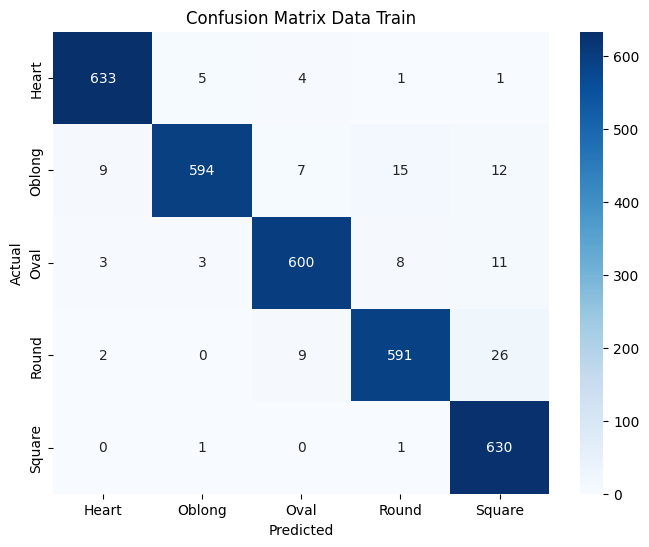

In [22]:
# @title Confusion Matrix Data Train

confusion_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Data Train')
plt.show()

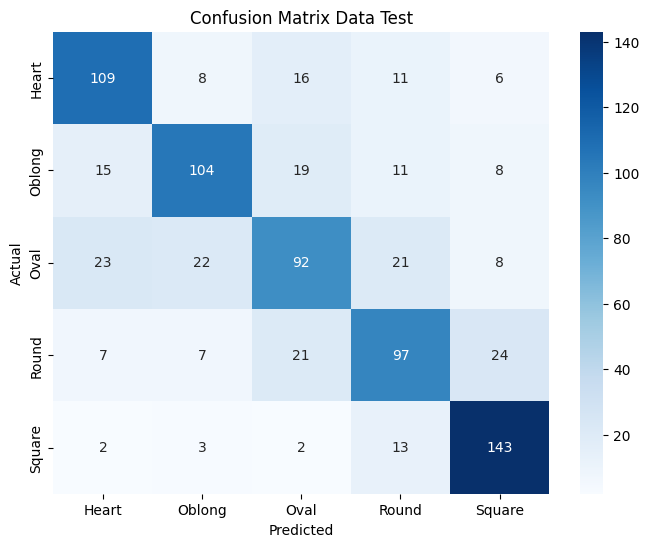

In [21]:
# @title Confusion Matrix Data Test

confusion_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Data Test')
plt.show()

In [8]:
# @title Clustering Menggunakan DBSCAN

dbscan = DBSCAN(eps=3, min_samples=2)

clusters = dbscan.fit_predict(features_scaled)

silhouette_avg = silhouette_score(features_scaled, clusters)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: -0.4987679571860915


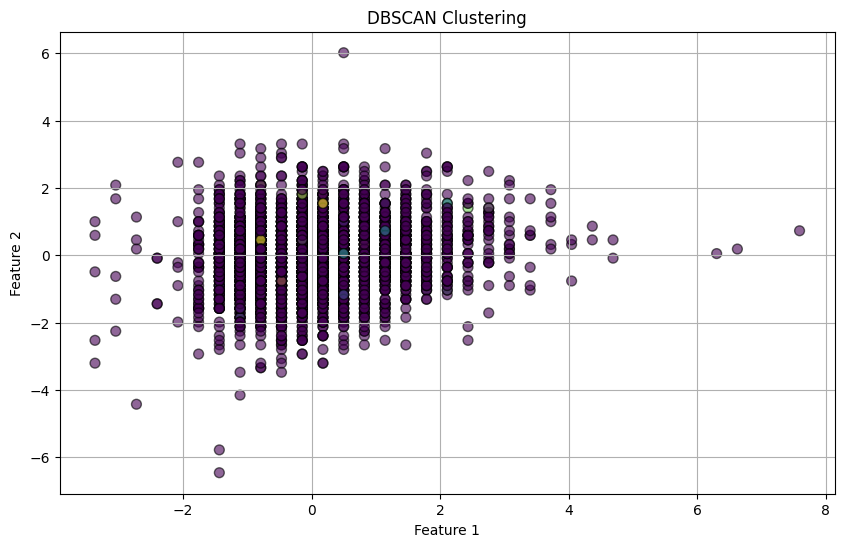

In [9]:
# @title Visualisasi Clustering

plt.figure(figsize=(10, 6))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=clusters, cmap='viridis', marker='o', s=50, alpha=0.6, edgecolors='k')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.show()